# Table of Contents

### 1 Scenario Generator
Generates a demand scenario for three commodities: maize, soybean and wheat, which is then fed into the simulator. Each demand trajectory consists out of a historic demand component and a scenario component. The scenario component can be created linearly, exponentially, exponentially linked to random seeding or can be predefined.
### 2 Simulator
Iterates through every year within the simulation window, is fed with demand scenario (see chapter 1), initial terminal setup and a list of investment triggers. All in all, the simulator produces a single *terminal* variable, under which all infrastructure and financial components are grouped (e.g. terminal.quays, terminal.capex, terminal.NPV etc.)
### 3 Investment Triggers Iteration
Runs the simulator (chapter 2) multiple times, while slight changing each investment trigger. The resulting *terminal* variables are saved in a list after which the impact of each trigger alteration can be visualised.
### 4 Risk Sensitivity Iteration
Runs the simulator (chapter 2) multiple times, while slight changing the presumed risk (quantified as weighted average cost of capital (WACC)). The resulting *terminal* variables are saved in a list after which the sensitivit to risk can be visualised.
### 5 Single Simulation Run 
Runs a single simulation (chapter 2) using predefined triggers
### 6 Plots
Result visualisations

In [1]:
import numpy as np
import pandas as pd

import terminal_optimization.visualisation        as visualisation
import terminal_optimization.forecast             as forecast
import terminal_optimization.investment_decisions as invest
import terminal_optimization.infrastructure       as infra
import terminal_optimization.financial_analysis   as financial
import terminal_optimization.initial_terminal     as initial

## 1 Scenario Generator

In [2]:
def scenario_generator(start_year, simulation_window):
    
    # Import commodities from package
    maize   = forecast.bulk_commodities(**forecast.maize_data)
    soybean = forecast.bulk_commodities(**forecast.maize_data)
    wheat   = forecast.bulk_commodities(**forecast.wheat_data)

    # Maize - Linear demand
    historic_demand_maize   = [1000000, 1100000, 1250000, 1400000, 1500000]        # demand at t=0
    historic_demand_maize   = [i * 3 for i in historic_demand_maize]
    
    # Growth scenario
    #predefined_demand_maize = [1600000, 1900000, 1900000, 1950000, 2000000, 2100000, 2150000, 2200000, 
    #                           2200000, 2250000, 2350000, 2400000, 2450000, 2550000, 2700000, 2900000, 
    #                           3000000, 3050000, 3150000, 3300000]
    
    # Erratic growth scenario
    #predefined_demand_maize = [1705000, 1883000, 1835000, 2090000, 2093000, 2100000, 2047000, 2341000, 
    #                           2549000, 2522000, 2670000, 2795000, 2717000, 2631000, 2561000, 2673000, 
    #                           2878000, 3105000, 3342000, 3323000]
    
    # Crisis scenario
    predefined_demand_maize = [1600000, 1900000, 1900000, 1950000, 1750000, 1600000, 1550000, 1530000, 
                               1570000, 1620000, 1700000, 1750000, 1800000, 1900000, 2050000, 2250000, 
                               2350000, 2400000, 2500000, 2650000]
    predefined_demand_maize = [i * 3 for i in predefined_demand_maize]

    # Soybean - Exponential demand
    historic_demand_soybean = 5*[0]
    rate_soybean = 1.06          # year on year growth rate of demand (% points) - input for constant method and random method

    # Wheat - Probabilistic demand
    historic_demand_wheat = 5*[0]
    rate_wheat  = 1.02
    mu_wheat    = 0.01          # avg bonus rate added to base rate (% points)  - input for random method
    sigma_wheat = 0.065         # standard deviation of bonus rate (% points)   - input for random method

    # Create demand scenario
    #maize.linear_scenario      (start_year, simulation_window, historic_demand_maize  , growth_maize)
    maize.predefined_scenario   (start_year, simulation_window, historic_demand_maize  , predefined_demand_maize)
    soybean.exponential_scenario(start_year, simulation_window, historic_demand_soybean, rate_soybean)
    wheat.random_scenario       (start_year, simulation_window, historic_demand_wheat  , rate_wheat, mu_wheat, sigma_wheat)
    commodities = [maize, soybean, wheat]
    
    # Import vessels from package
    handysize = forecast.vessel(**forecast.handysize_data)
    handymax  = forecast.vessel(**forecast.handymax_data)
    panamax   = forecast.vessel(**forecast.panamax_data)
    vessels = [handysize, handymax, panamax]
    
    # Calculate yearly calls
    vessels = forecast.vessel_call_calc(vessels, commodities, simulation_window)

    # Plot forecast
    visualisation.scenario(commodities, simulation_window, start_year)
    
    return vessels, commodities

## 2 Simulator

In [3]:
def simulate(terminal, vessels, commodities, start_year, simulation_window):
    
    for i in range (start_year, start_year + simulation_window):
        year = i 
        timestep = year - start_year

        ######################
        # Investment Decisions
        ######################           
        
        # Berths and cranes
        terminal.berths, terminal.cranes = invest.berth_invest_decision(terminal.berths, terminal.cranes, vessels, terminal.allowable_berth_occupancy, year, timestep, operational_hours)
        
        # Quay
        terminal.quays = invest.quay_invest_decision(terminal.quays, terminal.berths, year, timestep)

        # Storage
        storage_type            = 'Silos'
        trigger_throughput_perc = 10  # Percentage of annual throughput which triggers the investment in a new storage unit
        aspired_throughput_perc = 20  # Aspired of annual throughput which is realised due to the new storage unit
        terminal.storage = invest.storage_invest_decision(terminal.storage, trigger_throughput_perc, aspired_throughput_perc, storage_type, commodities, year, timestep)

        # Loading stations
        station_utilisation     = 0.60 # Loading station utilisation
        trigger_throughput_perc = 80   # Percentage of hourly peak demand which triggers the investment in a new loading unit
        aspired_throughput_perc = 120  # Aspired percentage of hourly peak demand which is realised due to the new loading unit
        terminal.stations = invest.station_invest_decision(terminal.stations, station_utilisation, trigger_throughput_perc, aspired_throughput_perc, commodities, year, timestep, operational_hours)

        # Conveyors
        terminal.quay_conveyors = invest.quay_conveyor_invest_decision(terminal.quay_conveyors, terminal.cranes, year, timestep, operational_hours)
        terminal.hinterland_conveyors = invest.hinterland_conveyor_invest_decision(terminal.hinterland_conveyors, terminal.stations, year, timestep, operational_hours)

        ######################
        # Business Logic
        ######################

        # Terminal throughput
        terminal = financial.throughput_calc(terminal, vessels, commodities, allowable_berth_occupancy, year, start_year, timestep, operational_hours)
        # Revenues
        terminal.revenues = financial.revenue_calc(terminal.revenues, terminal.throughputs, commodities, year, timestep)
        # Capex
        terminal.capex = financial.capex_calc(terminal, year, timestep)
        # Labour costs
        terminal.labour = financial.labour_calc(terminal, year, timestep, operational_hours)
        # Maintenance costs
        terminal.maintenance = financial.maintenance_calc(terminal, year, timestep)
        # Energy costs
        terminal.energy = financial.energy_calc(terminal, year, operational_hours, timestep)
        # Insurance costs
        terminal.insurance = financial.insurance_calc(terminal, year, timestep)
        # Lease costs 
        terminal.lease = financial.lease_calc(terminal, year,timestep)
        # Demurrage costs
        terminal.demurrage = financial.demurrage_calc(terminal.demurrage, terminal.berths, vessels, year, timestep)
        # Residual value calculations 
        terminal.residuals = financial.residual_calc(terminal, year, timestep)
        # Profits
        terminal.profits = financial.profit_calc(terminal, simulation_window, timestep, year, start_year)
        # Opex
        terminal.opex = financial.opex_calc(terminal, year, timestep)      
        
    #WACC depreciated profits
    terminal.WACC_cashflows = financial.WACC_calc(terminal.project_WACC, terminal.profits, simulation_window, start_year)

    # Combine all cashflows
    terminal.cashflows = financial.cashflow_calc(terminal, simulation_window, start_year) 
    
    #NPV 
    terminal.NPV = financial.NPV_calc(terminal.WACC_cashflows)
            
    return terminal

## 3 Investment Triggers Iteration

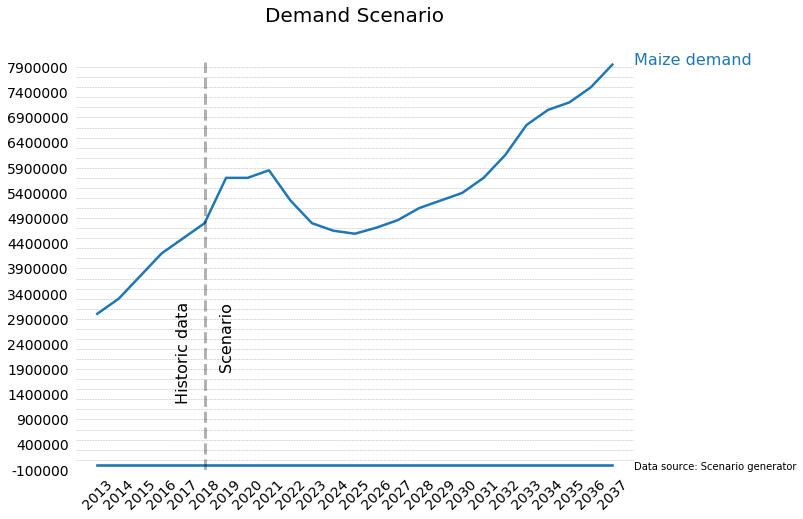

In [4]:
# Simulation parameters
start_year        = 2018   # start year of simulation
simulation_window = 20     # forecast 20 years
end_year          = start_year + simulation_window - 1
operational_hours = 4680   # operational hours per year

# Initial investment parameters
initial_max_berth_occupancy = 0.40
initial_max_waiting_time    = 0.20
initial_project_WACC        = 0.09

# Investment parameter spectrum
berth_occupancy_spectrum = range (20, 96, 1)
waiting_time_spectrum    = range (5, 40, 1)
project_WACC_spectrum    = range (50, 150, 1)
spectrum = []
spectrum.append(berth_occupancy_spectrum)
spectrum.append(waiting_time_spectrum)
spectrum.append(project_WACC_spectrum)

# Run scenario generator
vessels, commodities = scenario_generator(start_year, simulation_window)

# Run multiple simulations, while iterating through each investment trigger
results = []

# Iterate through allowable berth occupancies
iterations = []
for occupancy in berth_occupancy_spectrum:
    allowable_berth_occupancy = occupancy/100
    terminal = initial.terminal(initial_project_WACC, allowable_berth_occupancy, initial_max_waiting_time)
    terminal = simulate(terminal, vessels, commodities, start_year, simulation_window)
    iterations.append(terminal)
results.append(iterations)

# Iterate through allowable waiting times
iterations = []
for waiting_time in waiting_time_spectrum:
    allowable_waiting_time = waiting_time/100
    terminal = initial.terminal(initial_project_WACC, initial_max_berth_occupancy, allowable_waiting_time)
    terminal = simulate(terminal, vessels, commodities, start_year, simulation_window)
    iterations.append(terminal)
results.append(iterations)

# Iterate through project WACC
iterations = []
for WACC in project_WACC_spectrum:
    project_WACC = WACC/1000
    terminal = initial.terminal(project_WACC, initial_max_berth_occupancy, initial_max_waiting_time)
    terminal = simulate(terminal, vessels, commodities, start_year, simulation_window)
    iterations.append(terminal)
results.append(iterations)

,Iteration,NPV,Allowable occupancy
0,0,27636259,20
1,1,38755531,21
2,2,25372309,22
3,3,37299319,23
4,4,70544717,24
5,5,76433475,25
6,6,75964918,26
7,7,84643288,27
8,8,91823657,28
9,9,100198507,28


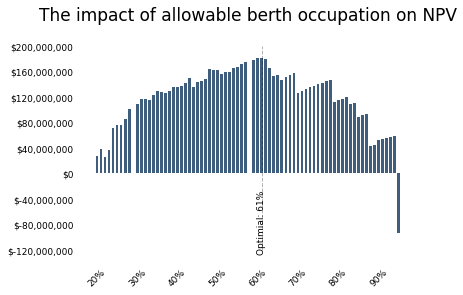

In [5]:
# Visualise NPV distribution as a result of allowable berth occupancy
occupancy_iterations = results[0]
visualisation.NPV_distribution_occupancy(occupancy_iterations)

,Iteration,NPV,Project WACC
0,0.0,372555184,5.0
1,1.0,368014331,5.1
2,2.0,363530860,5.2
3,3.0,359103908,5.3
4,4.0,354732625,5.4
5,5.0,350416178,5.5
6,6.0,346153746,5.6
7,7.0,341944523,5.7
8,8.0,337787715,5.8
9,9.0,333682543,5.9


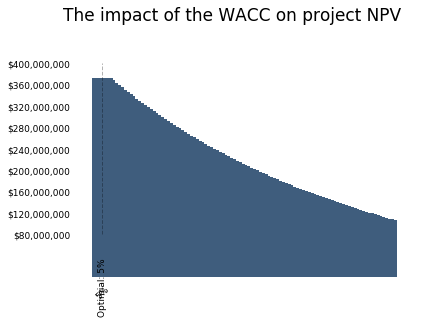

In [6]:
# Visualise NPV distribution as a result different project WACC's
WACC_iterations = results[2]
visualisation.NPV_distribution_WACC(WACC_iterations)

## 4 Risk Sensitivity Iteration

In [8]:
visualisation.revenue_capex_opex(terminal)

In [ ]:
visualisation.risk_sensitivity(cashflow_list, WACC_list)

## 5 Single Simulation Run

In [ ]:
# Import existing terminal infrastructure 
terminal = initial.terminal()

# Run simulation
allowable_occupancy = 0.62
WACC = 0.09
terminal = simulate(terminal, allowable_occupancy, WACC, vessels, commodities, start_year, simulation_window)

# Show NPV
print ("NPV: $" + str('{:0,.0f}'.format(terminal.NPV)))

## 6 Preliminary Plots

#### 6.1 Number of assets throughout the years

In [ ]:
visualisation.asset_trajectory(terminal, simulation_window, start_year)

#### 6.2 Revenue / Capex / Opex

In [ ]:
visualisation.revenue_capex_opex(terminal)

#### 6.3 Profit / Loss

In [ ]:
visualisation.profit_loss_pv(terminal)

#### 6.4 Demand vs. Capacity

In [ ]:
visualisation.throughput(terminal)

#### 6.5 Visualisation of predictive simulator

In [ ]:
#visualisation.consecutive_reative_trend(commodities, simulation_window, start_year)
#visualisation.consecutive_predictive_trend(commodities, simulation_window, start_year)